## Q2: Traffic Sign Detection

### Preparing Dataset

In [2]:
import requests, zipfile
from io import StringIO
import tensorflow as tf

In [ ]:
# do not run this unless you want to download and extract 1.5 gb of data
# this could take a while!
try:
    url="https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip"
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO(r.content))
    z.extractall("./data/FullIJCNN2013")
except:
    print("folder already exists!")

In [8]:
from PIL import Image
img = Image.open("./data/FullIJCNN2013/00000.ppm")

In [ ]:
from PIL import Image
import os
import numpy as np

def load_and_convert_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".ppm"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            tensor_img = tf.convert_to_tensor(np.array(img), dtype=tf.float32)
            images.append(tensor_img)
    return images

images = load_and_convert_images("./data/FullIJCNN2013/")

In [18]:
id_to_lable={0: "speed limit 20 (prohibitory)",
            1: "speed limit 30 (prohibitory)",
            2: "speed limit 50 (prohibitory)",
            3: "speed limit 60 (prohibitory)",
            4: "speed limit 70 (prohibitory)",
            5: "speed limit 80 (prohibitory)",
            6: "restriction ends 80 (other)",
            7: "speed limit 100 (prohibitory)",
            8: "speed limit 120 (prohibitory)",
            9: "no overtaking (prohibitory)",
            10: "no overtaking (trucks), (prohibitory)",
            11: "priority at next intersection (danger)",
            12: "priority road (other)",
            13: "give way (other)",
            14: "stop (other)",
            15: "no traffic both ways (prohibitory)",
            16: "no trucks (prohibitory)",
            17: "no entry (other)",
            18: "danger (danger)",
            19: "bend left (danger)",
            20: "bend right (danger)",
            21: "bend (danger)",
            22: "uneven road (danger)",
            23: "slippery road (danger)",
            24: "road narrows (danger)",
            25: "construction (danger)",
            26: "traffic signal (danger)",
            27: "pedestrian crossing (danger)",
            28: "school crossing (danger)",
            29: "cycles crossing (danger)",
            30: "snow (danger)",
            31: "animals (danger)",
            32: "restriction ends (other)",
            33: "go right (mandatory)",
            34: "go left (mandatory)",
            35: "go straight (mandatory)",
            36: "go right or straight (mandatory)",
            37: "go left or straight (mandatory)",
            38: "keep right (mandatory)",
            39: "keep left (mandatory)",
            40: "roundabout (mandatory)",
            41: "restriction ends (overtaking), (other)",
            42: "restriction ends (overtaking (trucks),), (other)"}

In [20]:
file= open("./data/FullIJCNN2013/gt.txt")
annotations={}
for f in file:
    line=f.split(';')
    if line[0] not in annotations.keys():
        annotations[line[0]]=[]
    annotations[line[0]].append([int(line[1]),int(line[2]),int(line[3]),int(line[4]),int(line[5])])

In [ ]:
tf_dataset = tf.data.Dataset.from_tensor_slices(images)

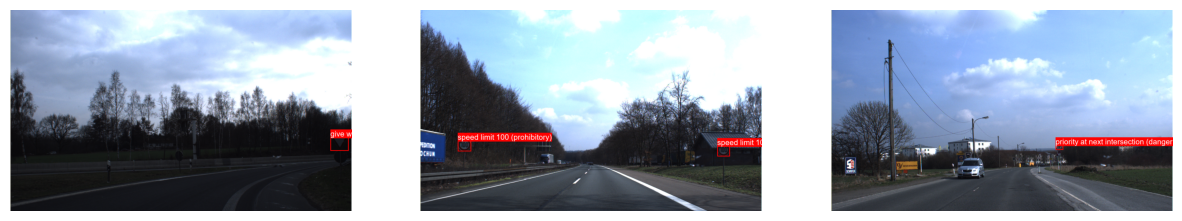

In [53]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random

def draw_annotations_on_image(img_idx, images, annotations):
    image = Image.fromarray((images[img_idx].numpy()).astype(np.uint8))
    draw = ImageDraw.Draw(image)

    if str(img_idx).zfill(5)+'.ppm' not in annotations.keys(): # no anotations
        return image
    
    for annotation in annotations[str(img_idx).zfill(5)+'.ppm']:
        rectangle_coords = (annotation[0], annotation[1], annotation[2], annotation[3])

        draw.rectangle(rectangle_coords, outline="red", width=3)

        text = id_to_lable[annotation[4]]
        text_position = (rectangle_coords[0], rectangle_coords[1] - 20) 
        font = ImageFont.truetype("arial.ttf", 30)
        _, _, width, height = draw.textbbox((0, 0), text=text, font=font)
        background_coords = (text_position[0], text_position[1], text_position[0] + width, text_position[1] + height) 
        draw.rectangle(background_coords, fill="red")
        draw.text(text_position, text, fill="white", font=font)

    return image

num_images=3
random_selected = [draw_annotations_on_image(random.randint(0, len(images)), images, annotations) for _ in range(num_images)]

fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for ax, img in zip(axes, random_selected):
    ax.imshow(img)
    ax.axis('off')

plt.show()